---

**Lesson 4** of the YT course:

[***Machine Learning for Audio Signals in Python - MLfAS***](https://www.youtube.com/playlist?list=PL6QnpHKwdPYjfCH2zkMGEHu2kv1HTICYA)

Original Jupyter Notebooks by [*Renato Profeta*](https://www.youtube.com/c/GuitarsAI)

---

In [ ]:
import numpy
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import time

device='cpu'
#device='cuda'

#Neural Network Detector for MNIST Digit Recognition

Now, we want to make a detector for our digits. 

We could train the recognizer of each digit class to output a "1" (or a value close to it) when it recognizes its digit, or a "0" (or a value close to it) when it is not recognizing its digit. If no digit is present, all detectors will output values close to 0, which is something that the classifier cannot do.

For that we use the same neural network structure as in part 3 for the MNIST classifier, but with a different Loss function. Instead of the CrossEntropyLoss(), we take the MSELoss(). But the MSELoss expects a different target representation.

For the CrossEntropyLoss, we need the class label (number) as the target, which means we have one integer (or float) input digit. The MSELoss expects a float number for each class, which means 10 float numbers for each input digit, where the correct class should have a "1", and all other classes should have a "0".

Since the MNSIT data set is made for classification, we need to convert its target to classes. We can do that by initializing a torch array with zeros, and then set it to "1" at the corresponding "correct" classes. This is also called a "one-hot" representation.

In [ ]:
batch_size_train = 100
batch_size_test = 10
num_classes = 10  #10 classes according to the 10 possible digits 0,...,9

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('~/Downloads/MNISTfiles/', 
    train=True, download=True,
    transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))])),
    batch_size=batch_size_train, shuffle=True)
#the Normalize() arguments are mean and standard deviation.

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('~/Downloads/MNISTfiles/', 
    train=False, download=True,
    transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))])),
    batch_size=batch_size_test, shuffle=True)

Extracting /root/Downloads/MNISTfiles/MNIST/raw/train-images-idx3-ubyte.gz to /root/Downloads/MNISTfiles/MNIST/raw


Extracting /root/Downloads/MNISTfiles/MNIST/raw/train-labels-idx1-ubyte.gz to /root/Downloads/MNISTfiles/MNIST/raw


Extracting /root/Downloads/MNISTfiles/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/Downloads/MNISTfiles/MNIST/raw


Extracting /root/Downloads/MNISTfiles/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/Downloads/MNISTfiles/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
examples = enumerate(train_loader)
# Plot ad hoc mnist instances

# load (downloaded if needed) the MNIST dataset
#(X_train, y_train), (X_test, y_test) = mnist.load_data()
#one trainig batch of 100 images:
batch_idx, (X_train, y_train) = next(examples)
print( "X_train.type()=",X_train.type(), "y_train.type()=",y_train.type())
print("batch_idx=", batch_idx, "X_train.shape=", X_train.shape, "y_train.shape=", y_train.shape, "y_train=", y_train)

#Make classes with one-hot encoding from the target classes:
#y_train_onehot=torch.zeros(batch_size_train,num_classes)
#for spl in range(batch_size_train):
    #y_train_onehot[spl, y_train[spl]]=1.0
y_train_onehot=torch.nn.functional.one_hot(y_train).type(torch.FloatTensor)
print("y_train_onehot=", y_train_onehot)

X_train.type()= torch.FloatTensor y_train.type()= torch.LongTensor
batch_idx= 0 X_train.shape= torch.Size([100, 1, 28, 28]) y_train.shape= torch.Size([100]) y_train= tensor([6, 3, 3, 4, 5, 1, 6, 5, 5, 9, 4, 0, 6, 2, 7, 7, 0, 7, 0, 1, 1, 3, 7, 5,
        0, 5, 8, 5, 2, 2, 9, 8, 8, 5, 2, 8, 8, 6, 7, 7, 2, 7, 1, 4, 0, 7, 4, 6,
        0, 3, 6, 9, 4, 9, 2, 6, 3, 9, 1, 9, 1, 7, 3, 2, 1, 6, 9, 5, 3, 7, 4, 9,
        2, 9, 0, 2, 4, 2, 4, 9, 3, 4, 5, 1, 5, 0, 6, 4, 1, 0, 3, 8, 1, 2, 6, 7,
        4, 5, 3, 1])
y_train_onehot= tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.

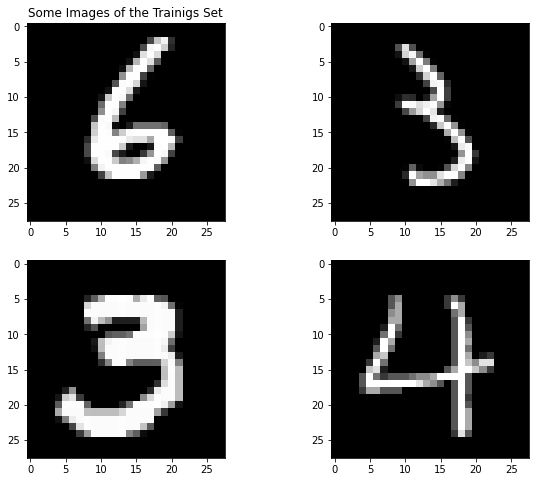

In [ ]:
examples = enumerate(test_loader)
#one test batch of batch_size_test images:
batch_idx, (X_test, y_test) = next(examples)
#Make classes with one-hot encoding from the target classes:
y_test_onehot=torch.zeros(batch_size_test,num_classes)
for spl in range(batch_size_test):
    y_test_onehot[spl, y_test[spl]]=1.0

# plot 4 images as gray scale
plt.figure(figsize=(10,8))
plt.subplot(221)
plt.title("Some Images of the Trainigs Set")
plt.imshow(X_train[0,0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1,0], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2,0], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3,0], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

In [ ]:
X_testunflat=X_test.clone() #keep original for imshow later
# flatten 28*28 images to a 784 vector for each image
num_pixels = X_train.shape[2] * X_train.shape[3]


#Flatten the images:
X_train = X_train.view(X_train.shape[0], num_pixels)
print("X_train.shape=",X_train.shape)
X_test = X_test.reshape(X_test.shape[0], num_pixels)
print("X_test.shape=",X_test.shape)

# normalize inputs from 0-255 to 0-1
#X_train = X_train / 255
#X_test = X_test / 255

# one hot encode outputs
#y_train = np_utils.to_categorical(y_train)
#y_test = np_utils.to_categorical(y_test)

X_train.shape= torch.Size([100, 784])
X_test.shape= torch.Size([10, 784])


In [ ]:
# define the neural network model
class DenseNet(nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()
        self.layer1=nn.Sequential(nn.Linear(in_features=num_pixels, out_features=num_pixels))
        self.layer2=nn.Sequential(nn.Linear(in_features=num_pixels, out_features=num_classes))
      
   
    def forward(self, x):
        x = F.relu(self.layer1(x))  #First layer with activation function
        x = self.layer2(x)   #Second layer
        #x = torch.nn.Softmax(x)
        return x

In [15]:
# build the model
print("Generate Model:")
model = DenseNet()#.to('cpu')
    
loss_fn = nn.MSELoss()
#learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters())#, lr=learning_rate)

# Fit the model
X_train=X_train.to(device)
y_train_onehot=y_train_onehot.to(device)
starttime=time.time()
for epoch in range(10):
    Ypred=model(X_train)
    loss=loss_fn(Ypred, y_train_onehot)
    if epoch%2==0:
        print(epoch, loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
       
endtime=time.time()
print("Duration of optimization:", endtime-starttime)
#model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=200, verbose=2)

Generate Model:
0 0.13651636242866516
2 0.07365607470273972
4 0.1580163985490799
6 0.04991782084107399
8 0.028712978586554527
Duration of optimization: 0.10409975051879883


In [ ]:
# Final evaluation of the model
Ypred=model(X_test)
loss=loss_fn(Ypred, y_test_onehot)
#scores = model.forward(X_test, y_test, verbose=0)
print("Loss on the test set:", loss)

Loss on the test set: tensor(0.0570, grad_fn=<MseLossBackward>)


In [12]:
import cv2
import numpy as np

In [13]:
#To test this case of an unknown image, we generate a 28x28 picture containing just random numbers between 0 and 1 (or 0 and 255 in a jpeg image).
rpic=np.random.rand(28,28)*255 #range for 8 bit unsigned integer
cv2.imwrite("./randpic.jpg", rpic);

Picture  0
X_testorig.shape= torch.Size([28, 28])
sample.shape= torch.Size([784])
Test Ypred= tensor([ 0.0578,  0.0845,  0.0020,  0.0404,  0.2039,  0.0488,  0.4521,  0.0065,
         0.0963, -0.0524], grad_fn=<AddBackward0>)
prediction= tensor(6)


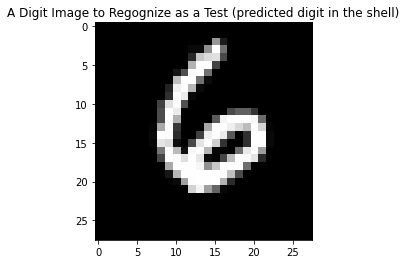

Picture  1
X_testorig.shape= torch.Size([28, 28])
sample.shape= torch.Size([784])
Test Ypred= tensor([ 0.3939, -0.5344,  0.4537, -0.0416,  0.0655, -0.4408, -0.1587,  0.0492,
         0.0879,  0.0450], grad_fn=<AddBackward0>)
prediction= tensor(2)


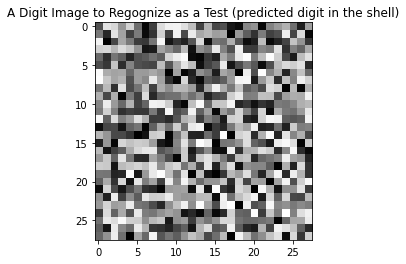

In [14]:
#"Inference", predict example digit test image:
for pic in range(2):
    print("Picture ", pic)
    if pic==0: #take image from test set:
        X_testorig=X_testunflat[1,0]
        sample=X_test[1,:]
    if pic==1: #read externa random test image, size 28x28 pixel:
        from PIL import Image
        image = Image.open('./randpic.jpg')
        import torchvision.transforms.functional as TF
        X_testorig = TF.to_tensor(image) 
        X_testorig = X_testorig[0,:,:]
        sample=X_testorig.view(28*28)
      
    print("X_testorig.shape=",X_testorig.shape)
    plt.imshow(X_testorig, cmap=plt.get_cmap('gray'))
    plt.title("A Digit Image to Regognize as a Test (predicted digit in the shell)")

    #sample=
    print("sample.shape=", sample.shape)
    Ypred=model(sample)
    print("Test Ypred=", Ypred)
    prediction=torch.argmax(Ypred) #use argmax as the class with the largest output
    print("prediction=", prediction)
    #Now we have the possibility to detect the case "probably not a digit" if the max output is too low,
    #since we know from the target function that perfect detection means "1.0" and 
    #perfect non-detection is "0.0",
    #by choosing some threshold:
    if Ypred[prediction] <0.4 : #not confident
        print("Probably not a digit")
    plt.show()